<a href="https://colab.research.google.com/github/mohith-vishwanath/Simple_Pytorch_Image_Classifier/blob/main/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Necessary Imports**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, clear_output
import pandas as pd
import time
import json

from itertools import product
from collections import namedtuple
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import time
from pprint import pprint

torch.set_printoptions(linewidth=120)
# torch.set_grad_enabled(False)

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.8.1+cu101
0.9.1+cu101


In [3]:
#Check if GPU is available
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
    print("GPU available")
else:
    device = "cpu"
    print("Only CPU available")

GPU available


### **Download FashionMNIST dataset**

In [4]:
#Training set
train_set = torchvision.datasets.FashionMNIST(
    root = "",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [5]:
#Testing set
test_set = torchvision.datasets.FashionMNIST(
    root = "",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [6]:
#Number of data points for each class
train_set.targets.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [7]:
#Number of data points for each class
test_set.targets.bincount()

tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

### **Analysing Dataset**

Label : 9


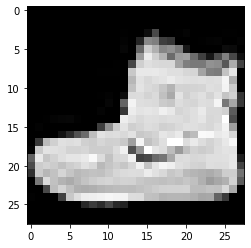

In [8]:
sample_iter = iter(train_set)
sample = next(sample_iter)
image, target = sample

plt.imshow(image.squeeze(),cmap="gray")
print("Label : " + str(target))

### **Helper Functions**

In [9]:
#This class returns all the combinations of hyperparameters with which the model needs to be trained

class RunBuilder:
    @staticmethod
    def get_runs(params):
        Runs = namedtuple("Run",params.keys())
        runs = []
        for v in product(*params.values()):
            runs.append(Runs(*v))
        return runs

In [22]:
class RunManager:
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None

        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None

        self.network = None
        self.loader = None
        self.dataframe = None

    def begin_run(self, run, network, loader):
        self.run_start_time = time.time()

        self.run_params = run
        self.run_count += 1

        self.network = network
        self.loader = loader

        images, labels = next(iter(self.loader))
    
    def end_run(self):
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()

        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)

        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results['loss'] = loss
        results["accuracy"] = accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
    
    def track_loss(self, loss, batch):
        self.epoch_loss += loss.item() * batch[0].shape[0]

    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
    
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName):
        self.dataframe = pd.DataFrame.from_dict(
            self.run_data, orient='columns'
        )
        self.dataframe.to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

### **The Neural Network**


In [11]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)

        self.fc1 = nn.Linear(in_features=192,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=60)
        self.out = nn.Linear(in_features=60,out_features=10)
    

    def forward(self,t):
        #Layer1
        t = t

        #Layer2
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)

        #Layer3
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)

        #Layer4
        t = t.reshape(-1,12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        #Layer5
        t = self.fc2(t)
        t = F.relu(t)

        #Layer6
        t = self.out(t)
        # t = F.softmax(t)

        return t

In [31]:
params = OrderedDict(
    lr = [.01,0.001,0.005]
    ,batch_size = [100,500,1000]
    ,shuffle=[True]
)

In [35]:
num_of_epochs = 20
hyper_sets = RunBuilder.get_runs(params)

print("Number of epochs per set of hyperparameters - ", str(num_of_epochs))
print("Number of sets of hyperparameters - ",len(hyper_sets))
print("Total number of epochs - ",len(hyper_sets)*num_of_epochs)
print("Training on - ",device)
print("***************************************************************************\n")
m = RunManager()
for run in hyper_sets:
    network = Network()
    network = network.to(device)
    loader = DataLoader(train_set,batch_size=run.batch_size,shuffle=run.shuffle)
    optimizer = optim.Adam(network.parameters(),lr=run.lr)
    m.begin_run(run,network,loader)
    print(f'Run {m.run_count} | {run} \n')
    for epoch in range(num_of_epochs):
        m.begin_epoch()
        for batch in loader:
            images, labels = batch

            images = images.to(device)
            labels = labels.to(device)

            preds = network(images)
            loss = F.cross_entropy(preds,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            m.track_loss(loss,batch)
            m.track_num_correct(preds,labels)

        print("Epoch : " + str(epoch+1) + " | accuracy : " + str(round((m.epoch_num_correct/len(train_set))*100,3)) + "% | loss : " + str(round(m.epoch_loss,5)) + " | time : " + str(round(time.time()-m.epoch_start_time,4)) + "s")
        m.end_epoch()
    m.end_run()
    print("***************************************************************************\n")
m.save("results")

Number of epochs per set of hyperparameters -  20
Number of sets of hyperparameters -  9
Total number of epochs -  180
Training on -  cuda:0
***************************************************************************

Run 1 | Run(lr=0.01, batch_size=100, shuffle=True) 

Epoch : 1 | accuracy : 78.222% | loss : 34246.05525 | time : 4.8531s
Epoch : 2 | accuracy : 85.467% | loss : 23460.81052 | time : 4.908s
Epoch : 3 | accuracy : 86.718% | loss : 21286.26548 | time : 4.9227s
Epoch : 4 | accuracy : 87.452% | loss : 20331.44021 | time : 4.8807s
Epoch : 5 | accuracy : 87.748% | loss : 19846.24372 | time : 4.8381s
Epoch : 6 | accuracy : 88.132% | loss : 19125.29515 | time : 4.8918s
Epoch : 7 | accuracy : 88.303% | loss : 18823.90784 | time : 4.9097s
Epoch : 8 | accuracy : 88.65% | loss : 18366.41599 | time : 4.8309s
Epoch : 9 | accuracy : 88.813% | loss : 18125.35339 | time : 4.9009s
Epoch : 10 | accuracy : 88.863% | loss : 18181.04372 | time : 4.8053s
Epoch : 11 | accuracy : 89.19% | loss : 

In [36]:
m.dataframe

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.570768,0.782217,4.853228,4.867758,0.010,100,True
1,1,2,0.391014,0.854667,4.908103,9.775888,0.010,100,True
2,1,3,0.354771,0.867183,4.922814,14.698740,0.010,100,True
3,1,4,0.338857,0.874517,4.880850,19.579617,0.010,100,True
4,1,5,0.330771,0.877483,4.838227,24.417870,0.010,100,True
...,...,...,...,...,...,...,...,...,...
175,9,16,0.302149,0.887217,3.820917,61.955592,0.005,1000,True
176,9,17,0.298483,0.889833,3.814975,65.770595,0.005,1000,True
177,9,18,0.290706,0.893050,3.977161,69.747782,0.005,1000,True
178,9,19,0.284781,0.894467,3.830544,73.578352,0.005,1000,True


In [37]:
test_set_loader = torch.utils.data.DataLoader(test_set,batch_size=100,shuffle=True)
correct = 0
with torch.no_grad():
    for batch in test_set_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        preds = network(images)
        correct += get_num_correct_pred(preds,labels)

    result = (correct/len(test_set)).item()
    print(round(result,4)*100,"%")

NameError: ignored